# BERTopic

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import df_to_list

In [2]:
import pandas as pd
from utils.cargar import df_caso
from utils.preprocesamiento import process_df

op_left, op_right = 'Priorizar criterios técnicos', 'Priorizar plazos'

caso = 'alicia'
df = df_caso(caso)

df = process_df(df,'comment','sel',verbose=True)

train_indices = pd.read_csv('../utils/splits/train_indices_{}.csv'.format(caso), header=None)[0].tolist()
test_indices = pd.read_csv('../utils/splits/test_indices_{}.csv'.format(caso), header=None)[0].tolist()
print("Partición train-test cargada")

df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

80 rows found with non string elements for column comment (0.65%)
Deleting 2326 columns for which max target value is over 7 (18.76%)
9991 available rows after processing
Partición train-test cargada


Guardando la partición train-test

In [3]:
from utils.preprocesamiento import StemmerTokenizer

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True)

docs_train = df_to_list(df_train,'comment',tokenizador)
docs_test = df_to_list(df_test, 'comment',tokenizador)

## BERTopic algorithm

In [4]:
from IPython.display import Image, display
display(Image(url='https://maartengr.github.io/BERTopic/algorithm/modularity.svg'))

In [5]:
%%capture
from bertopic import BERTopic

In [6]:
model = BERTopic(language="spanish",min_topic_size=10,nr_topics=25,calculate_probabilities=True)

In [7]:
%%time
topics, probs = model.fit_transform(docs_train)

CPU times: user 1min 42s, sys: 3.48 s, total: 1min 46s
Wall time: 42.9 s


In [8]:
model.get_topic_freq().head(5)

,Topic,Count
2,-1,2619
1,0,2204
0,1,1619
11,2,527
10,3,360


In [9]:
model.get_topic(0)[:10]

[('alicia', 0.05611952956351237),
 ('proyecto', 0.02757794562857878),
 ('debería', 0.024787733646290326),
 ('debe', 0.021328654913866627),
 ('si', 0.01967600292216638),
 ('usuarios', 0.01846164771283158),
 ('priorizar', 0.017487576575556534),
 ('ser', 0.01662153142177055),
 ('cumplir', 0.01599434454836954),
 ('entregar', 0.015757024054962345)]

Topicos para algunos documentos

In [10]:
for i, t in enumerate(model.topics_[:10]):
    print('Tópico {}:\ttexto: {}'.format(t,docs_train[i]))

Tópico 1:	texto: entrega producto defectuoso cumple ética ingeniero
Tópico 1:	texto: Creo reputación manchada ser transparente sino contrario podría ser mejor solución
Tópico 0:	texto: Alicia debería ser transparente dicho anteriormente ser transparente parte personalidad además puede justificar buena manera salir éxito
Tópico 1:	texto: especificaciones técnicas deberían ser transparentes evitar problemas largo plazo
Tópico -1:	texto: Si finalizó proyecto entregado falencias importante ser responsable riesgos pueda generar largo plazo pesar seguros impedirán funcionalidad si alguien va usar producto final debe consciente acabado pensó principio conozca contexto globalmente sepa cómo reaccionar caso próximos errores capaz discernir cuenta próximas mejorar producto necesita vista terminado criterios requerían principio A parte punto vista ocultar verdad consecuente valores trabajadora enseñó años formación profesional conscientes contingencia mundial importante ser responsable consecuent

### Inferencia en conjunto test

In [11]:
string = 'Aun considero necesario resguardar mas tradiciones identitarias embargo producir alimento podría ayudar muchas personas entonces debería existir diálogo ambas partes llegar mejor solución'

model.transform([string])

([11],
 array([[7.69229170e-39, 6.44327631e-39, 4.57928368e-37, 2.25861022e-37,
         1.77549951e-37, 8.23752945e-39, 1.62891500e-37, 9.41283565e-38,
         3.61781712e-37, 1.30205389e-37, 1.27366840e-37, 9.77256288e-01,
         1.48323155e-38, 8.30250348e-38, 4.32248383e-38, 5.30729359e-38,
         1.56840880e-35, 6.33932852e-37, 5.67676136e-38, 9.59558582e-39,
         5.78142768e-37, 2.17520189e-38, 8.15779565e-39, 1.95902972e-38]]))

In [12]:
output = model.transform(df_to_list(df_test.iloc[:3],'comment',tokenizador))

Imprimiendo los embeddings

In [13]:
output[1]

array([[0.00672482, 0.16383261, 0.06127071, 0.02005259, 0.03805146,
        0.00496062, 0.01732934, 0.01127731, 0.04133247, 0.01719676,
        0.01005304, 0.01015466, 0.09114773, 0.01863648, 0.00466238,
        0.00584245, 0.00527474, 0.00489766, 0.00547197, 0.00467804,
        0.0048228 , 0.00583755, 0.00713483, 0.00591226],
       [0.00104119, 0.00096731, 0.04413027, 0.01281296, 0.01864438,
        0.00092213, 0.01392894, 0.51644057, 0.03593289, 0.01387422,
        0.00654977, 0.0059433 , 0.00230354, 0.01041493, 0.00225007,
        0.0049964 , 0.00337494, 0.00266805, 0.00571192, 0.00127167,
        0.00256826, 0.00346244, 0.00142867, 0.00293094],
       [0.18087628, 0.01231951, 0.14339083, 0.04882821, 0.08423556,
        0.0143059 , 0.03547332, 0.02286616, 0.09204843, 0.03661317,
        0.02396394, 0.02317908, 0.02501759, 0.03660954, 0.01096961,
        0.01216117, 0.0115873 , 0.01130964, 0.01144043, 0.01130801,
        0.01126406, 0.01193805, 0.01221274, 0.0118379 ]])

In [14]:
output[0]

[1, 7, 0]

Visualización

In [15]:
model.visualize_topics()

Podemos relacionar tópicos con palabras en específico

In [16]:
target = 'integridad'

topic_num = 5

similar_topics, similarity = model.find_topics(target, top_n=topic_num)
similar_topics

[23, 16, 14, 12, 1]

In [17]:
similarity

[0.6150635646667274,
 0.5894751090043417,
 0.5311439861401046,
 0.5172437787309745,
 0.5037999837043818]

In [18]:
from TM_utils import get_table_top_topics
from utils.exploracion import print_table_md

print("Tópicos relevantes para concepto: {}".format(target))

headers, data = get_table_top_topics(model,similar_topics,similarity,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para concepto: integridad


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| 23 | 0.6150635646667274 | seguridad | estándares | va | inlcuyendo | ingeniería |
| 16 | 0.5894751090043417 | ambas | cumplir | debe | ocurrio | responsabilidaded |
| 14 | 0.5311439861401046 | idem | sorry | lo | alcance | mismo |
| 12 | 0.5172437787309745 | ética | éticos | ético | hecho | bien |
| 1 | 0.5037999837043818 | reputación | transparencia | ser | transparente | mantener |


Distribución de tópicos en test set

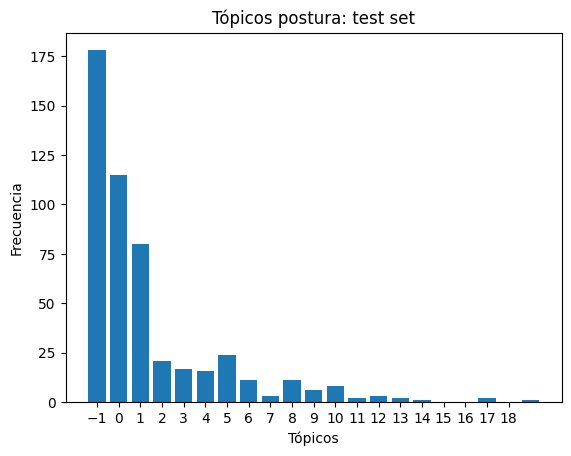

In [20]:
from TM_utils import plot_frecuencies, get_top_k_topics, get_table_top_topics
from utils.exploracion import print_table_md
from utils.preprocesamiento import StemmerTokenizer

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True)

output_test = model.transform(df_to_list(df_test,'comment',tokenizador))

plot_frecuencies(output_test[0],label='test set')

In [21]:
top_5_keys, top_5_values = get_top_k_topics(output_test[0],k=5)
print("Tópicos relevantes en test set")

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes en test set


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| -1 | 0.35528942115768464 | proyecto | criterios | plazos | si | técnicos |
| 0 | 0.22954091816367264 | alicia | proyecto | debería | debe | si |
| 1 | 0.1596806387225549 | reputación | transparencia | ser | transparente | mantener |
| 5 | 0.04790419161676647 | pandemia | contexto | condiciones | acuerdos | proyecto |
| 2 | 0.041916167664670656 | proyecto | plazos | entregar | importante | bien |


In [23]:
from TM_utils import get_k_random_samples_from_topic

for topic in top_5_keys:
    df_samples, certainties = get_k_random_samples_from_topic(df_test,output_test,topic)

    print("Samples for topic ", topic)
    for i in range(len(df_samples)):
        print("Certainty:",certainties[i],"Text:", df_samples.iloc[i]['comment'])
    print('\n')

Samples for topic  -1
Certainty: 6.800650820867992e-11 Text: Aquí debe cumplir con lo elemental con el usuario, pero tratar de apegarse más a los plazos, para así poder no sentirse sometida a tanta presión y rendir como es debido
Certainty: 7.751935378870992e-10 Text: debe cumplir con los acuerdos acorde al contexto ya que es preferible que se demore un poco más el proyecto y finalizado este, se entregue un producto completamente funcional y que no afecte a los usuarios.
Certainty: 4.953213646386584e-183 Text: Deberia priorizar los criterios tecnicos para que el producto este en su maximo funcionamiento y genere la mayor satisfacción a sus usuarios.
Certainty: 8.731025165310957e-11 Text: Se debe a que los plazos tampoco se deben extender tanto, porque las consecuencias económicas pueden perjudicar en el proyecto, pero siempre respetando las etapas de producción del producto y del proyecto en general, para lograr algo bien hecho.
Certainty: 0.00047573644479022607 Text: Es de mayor prior

### Analizando correlaciones con selección de postura

Por el momento binarizando la postura

In [24]:
df_test.loc[(df_test['sel']==2) | (df_test['sel']==3),'sel'] = 1
df_test.loc[(df_test['sel']==4) | (df_test['sel']==5),'sel'] = 6

In [25]:
output_sel1 = model.transform(df_to_list(df_test[df_test['sel']==1],'comment',tokenizador))

In [26]:
output_sel6 = model.transform(df_to_list(df_test[df_test['sel']==6],'comment',tokenizador))

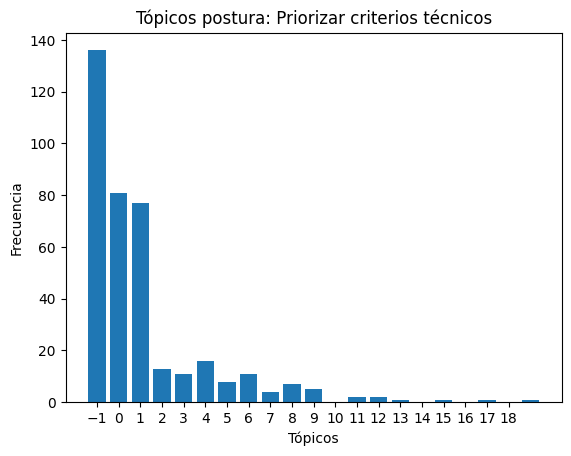

In [27]:
plot_frecuencies(output_sel1[0],label=op_left)

In [28]:
top_5_keys, top_5_values = get_top_k_topics(output_sel1[0])

print("Tópicos relevantes para postura: {}".format(op_left))

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para postura: Priorizar criterios técnicos


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| -1 | 0.36074270557029176 | proyecto | criterios | plazos | si | técnicos |
| 0 | 0.21485411140583555 | alicia | proyecto | debería | debe | si |
| 1 | 0.20424403183023873 | reputación | transparencia | ser | transparente | mantener |
| 4 | 0.042440318302387266 | usuario | usuarios | proyecto | necesidades | criterios |
| 2 | 0.034482758620689655 | proyecto | plazos | entregar | importante | bien |


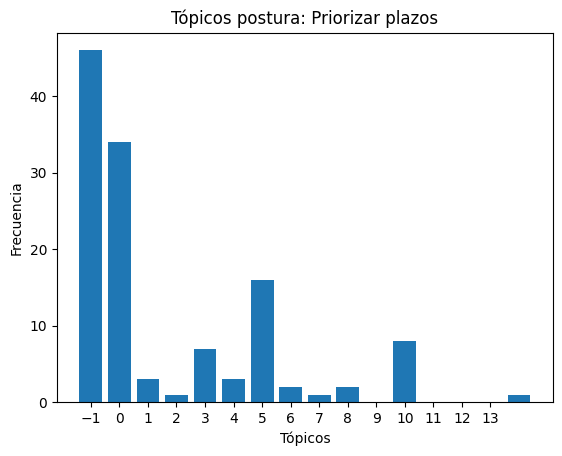

In [29]:
plot_frecuencies(output_sel6[0],label=op_right)

In [30]:
top_5_keys, top_5_values = get_top_k_topics(output_sel6[0])

print("Tópicos relevantes para postura: {}".format(op_right))

headers, data = get_table_top_topics(model,top_5_keys,top_5_values,max_w=5)
print_table_md(headers, data)

Tópicos relevantes para postura: Priorizar plazos


| Tópico | Probabilidad | Palabra 1 | Palabra 2 | Palabra 3 | Palabra 4 | Palabra 5 |
| --- | --- | --- | --- | --- | --- | --- |
| -1 | 0.3709677419354839 | proyecto | criterios | plazos | si | técnicos |
| 0 | 0.27419354838709675 | alicia | proyecto | debería | debe | si |
| 5 | 0.12903225806451613 | pandemia | contexto | condiciones | acuerdos | proyecto |
| 10 | 0.06451612903225806 | contexto | condiciones | contextuales | proyecto | importante |
| 3 | 0.056451612903225805 | acuerdos | cumplir | condiciones | contexto | acuerdo |


### Correlaciones

In [31]:
import pandas as pd

df_test = df.iloc[test_indices]
df_test['sel'].value_counts()

arr_test = model.transform(df_to_list(df_test,'comment',tokenizador))[1]
df_topics = pd.DataFrame(arr_test, columns=['Topic{}'.format(i+1) for i in range(24)])

df_topics['sel'] = df_test['sel'].values

In [32]:
from scipy.stats import pearsonr

# Only compute pearson prod-moment correlations between feature
# columns and target column
target_col_name = 'sel'
feature_target_corr = {}
for col in df_topics:
    if target_col_name != col:
        feature_target_corr[col + '_' + target_col_name] = \
            pearsonr(df_topics[col], df_topics[target_col_name])[0]
print("Feature-Target Correlations")

for k in feature_target_corr.keys():
    print(k+': '+str(feature_target_corr[k]))

Feature-Target Correlations
Topic1_sel: 0.015756397572885706
Topic2_sel: -0.23783405620204057
Topic3_sel: 0.010790238046978342
Topic4_sel: 0.1505629038186321
Topic5_sel: -0.046031705333791396
Topic6_sel: 0.24077511417332315
Topic7_sel: -0.0694392271061921
Topic8_sel: -0.013750693039842363
Topic9_sel: 0.012856463421820185
Topic10_sel: 0.006937712979479507
Topic11_sel: 0.21026512830057403
Topic12_sel: 0.07115611333110283
Topic13_sel: -0.0482335619294286
Topic14_sel: -0.056543532390170057
Topic15_sel: 0.11624411212609925
Topic16_sel: -0.01963149489859377
Topic17_sel: 0.002246047800889267
Topic18_sel: 0.0445950075310119
Topic19_sel: -0.009663928319222087
Topic20_sel: -0.015312170470469956
Topic21_sel: 0.04795442236089221
Topic22_sel: 0.022075590619253578
Topic23_sel: 0.04257558452799318
Topic24_sel: 0.04880900690197362


Guardando el modelo

In [33]:
model.save("modelos/BT-{}.bertopic".format(caso))

Para cargar:

`my_model = BERTopic.load("modelos/BT-caso.bertopic")`